In [1]:
import numpy as np
from datetime import datetime
from datetime import timedelta
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
from datetime import datetime
plt.rcParams['figure.figsize'] = [15, 7.5]
plt.rcParams.update({'font.size': 16,'legend.fontsize':16})
import seaborn as sns
import sys
import os
from config import get_from_config, save_to_config
import fur.path_assistant as path_assistant
from fur.waveform_reader import read_waveform
from fur.finding_period import get_period
from fur.fluctuations import get_fluctiation_and_noise_var, get_average_signal
shift_03_16_2020 = path_assistant.PathAssistant('shift_03_16_2020', ignore_files=["RefCurve_2020-03-16_0_084020_test.Wfm.bin"])
waveforms_dir = shift_03_16_2020.get_waveforms_dir()
results_dir = shift_03_16_2020.get_results_dir()
additional_data_dir = shift_03_16_2020.get_additional_data_dir()
bpm_files_df = shift_03_16_2020.get_bpm_files_df()
acnet_data_df = shift_03_16_2020.get_acnet_data_df("all_acnet_data_ROUND_case_03_16_2020.csv")
t1 = datetime(2020, 3, 16, 13, 46, 0)
t2 = datetime(2020, 3, 16, 14, 25, 0)

In [2]:
fluctuation_waveforms_df = shift_03_16_2020.get_fluctuation_waveforms_df()

In [3]:
fluctuation_waveforms_df = fluctuation_waveforms_df[(fluctuation_waveforms_df["file_datetime"] > t1) \
& (fluctuation_waveforms_df["file_datetime"]<t2)].reset_index()

In [4]:
fluctuation_waveforms_df["real_file_datetime"] = fluctuation_waveforms_df["file_datetime"]+pd.Timedelta(get_from_config("RS_scope_time_behind_sec"), unit='s')

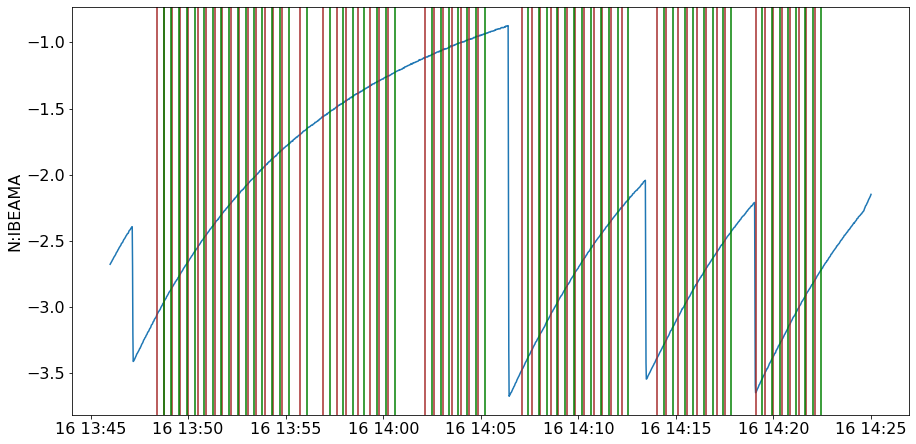

In [5]:
ax = sns.lineplot(x=acnet_data_df.index, y=acnet_data_df["N:IBEAMA"])
for t in fluctuation_waveforms_df["file_datetime"]:
    plt.axvline(t, color="brown")
for t in fluctuation_waveforms_df["real_file_datetime"]:
    plt.axvline(t, color="green")
plt.show()

In [6]:
fluctuation_waveforms_df["rounded_real_file_datetime"] = \
    fluctuation_waveforms_df["real_file_datetime"].apply(lambda t: t.round(freq='S'))

In [7]:
fluctuation_waveforms_df["N:IBEAMA"] = fluctuation_waveforms_df["rounded_real_file_datetime"] \
    .apply(lambda t: acnet_data_df.loc[t, "N:IBEAMA"])

In [8]:
res_df = shift_03_16_2020.get_fluctuations_df("res_df_comb_filter_no_nd_filters_ROUND_data_03_16_2020.csv")

In [9]:
current = -get_from_config("IBEAM_to_WCM_ABSOLUTE")*fluctuation_waveforms_df["N:IBEAMA"].values
amplitude = res_df["ch2_amplitude"].values

In [10]:
reg = linear_model.LinearRegression(fit_intercept=False)
x = current
y = amplitude
reg.fit(x.reshape((len(x), 1)), y)
a = reg.coef_[0]
a

0.21449837419264767

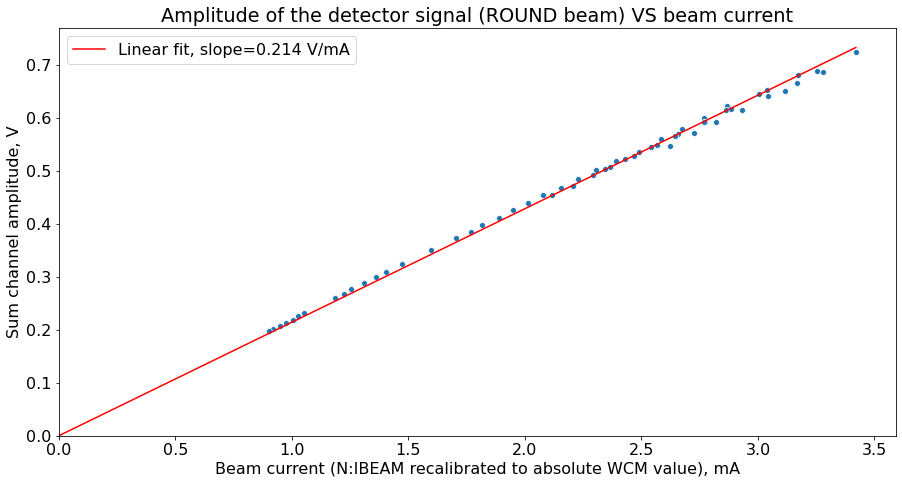

In [11]:
ax = sns.scatterplot(current, amplitude)
ax2 = sns.lineplot(x=[0, max(current)],y=[0, a*max(current)], color='red',
    label="Linear fit, slope={:.3f} V/mA".format(a))
ax.set_xlabel("Beam current (N:IBEAM recalibrated to absolute WCM value), mA")
ax.set_ylabel("Sum channel amplitude, V")
ax.set_ylim(0, ax.get_ylim()[1])
ax.set_xlim(0, ax.get_xlim()[1])
ax.set_title("Amplitude of the detector signal (ROUND beam) VS beam current")
plt.show()

The slope is not exactly the one for directly connected case devided by sqrt(2)

In [12]:
0.3516107535210208/np.sqrt(2)

0.24862634815282553